### Import packages

In [1]:
import itertools
import numpy as np
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

from utilities import cal_score, convert_types

### Columns

In [2]:
cols_num = ['txn_dt', 'total_floor', 'building_complete_dt', 'parking_area', 'parking_price', 'txn_floor', 'land_area', 'building_area', 'lat', 'lon', 'village_income_median', 'town_population', 'town_area', 'town_population_density', 'doc_rate', 'master_rate', 'bachelor_rate', 'jobschool_rate', 'highschool_rate', 'junior_rate', 'elementary_rate', 'born_rate', 'death_rate', 'marriage_rate', 'divorce_rate', 'N_50', 'N_500', 'N_1000', 'N_5000', 'N_10000', 'I_10', 'I_50', 'I_100', 'I_250', 'I_500', 'I_1000', 'I_5000', 'I_10000', 'I_MIN', 'II_10', 'II_50', 'II_100', 'II_250', 'II_500', 'II_1000', 'II_5000', 'II_10000', 'II_MIN', 'III_10', 'III_50', 'III_100', 'III_250', 'III_500', 'III_1000', 'III_5000', 'III_10000', 'III_MIN', 'IV_10', 'IV_50', 'IV_100', 'IV_250', 'IV_500', 'IV_1000', 'IV_5000', 'IV_10000', 'IV_MIN', 'V_10', 'V_50', 'V_100', 'V_250', 'V_500', 'V_1000', 'V_5000', 'V_10000', 'V_MIN', 'VI_50', 'VI_100', 'VI_250', 'VI_500', 'VI_1000', 'VI_5000', 'VI_10000', 'VI_MIN', 'VII_10', 'VII_50', 'VII_100', 'VII_250', 'VII_500', 'VII_1000', 'VII_5000', 'VII_10000', 'VII_MIN', 'VIII_10', 'VIII_50', 'VIII_100', 'VIII_250', 'VIII_500', 'VIII_1000', 'VIII_5000', 'VIII_10000', 'VIII_MIN', 'IX_10', 'IX_50', 'IX_100', 'IX_250', 'IX_500', 'IX_1000', 'IX_5000', 'IX_10000', 'IX_MIN', 'X_10', 'X_50', 'X_100', 'X_250', 'X_500', 'X_1000', 'X_5000', 'X_10000', 'X_MIN', 'XI_10', 'XI_50', 'XI_100', 'XI_250', 'XI_500', 'XI_1000', 'XI_5000', 'XI_10000', 'XI_MIN', 'XII_10', 'XII_50', 'XII_100', 'XII_250', 'XII_500', 'XII_1000', 'XII_5000', 'XII_10000', 'XII_MIN', 'XIII_10', 'XIII_50', 'XIII_100', 'XIII_250', 'XIII_500', 'XIII_1000', 'XIII_5000', 'XIII_10000', 'XIII_MIN', 'XIV_10', 'XIV_50', 'XIV_100', 'XIV_250', 'XIV_500', 'XIV_1000', 'XIV_5000', 'XIV_10000', 'XIV_MIN']
cols_cat = ['building_material', 'city', 'building_type', 'building_use', 'parking_way', 'town', 'village']
cols_bin = ['I_index_50', 'I_index_500', 'I_index_1000', 'II_index_50', 'II_index_500', 'II_index_1000', 'III_index_50', 'III_index_500', 'III_index_1000', 'IV_index_50', 'IV_index_500', 'IV_index_1000', 'IV_index_5000', 'V_index_50', 'V_index_500', 'V_index_1000', 'VI_10', 'VI_index_50', 'VI_index_500', 'VI_index_1000', 'VII_index_50', 'VII_index_500', 'VII_index_1000', 'VIII_index_50', 'VIII_index_500', 'VIII_index_1000', 'IX_index_50', 'IX_index_500', 'IX_index_1000', 'IX_index_5000', 'X_index_50', 'X_index_500', 'X_index_1000', 'XI_index_50', 'XI_index_500', 'XI_index_1000', 'XI_index_5000', 'XI_index_10000', 'XII_index_50', 'XII_index_500', 'XII_index_1000', 'XIII_index_50', 'XIII_index_500', 'XIII_index_1000', 'XIII_index_5000', 'XIII_index_10000', 'XIV_index_50', 'XIV_index_500', 'XIV_index_1000']
cols_feats_origin = cols_num + cols_cat + cols_bin

col_target = 'total_price'
col_target_log1p = 'target'

### Read data

In [3]:
df = pd.read_csv('dataset/train.csv', dtype=object)

In [4]:
df.columns

Index(['building_id', 'building_material', 'city', 'txn_dt', 'total_floor',
       'building_type', 'building_use', 'building_complete_dt', 'parking_way',
       'parking_area',
       ...
       'XIV_500', 'XIV_index_500', 'XIV_1000', 'XIV_index_1000', 'XIV_5000',
       'XIV_index_5000', 'XIV_10000', 'XIV_index_10000', 'XIV_MIN',
       'total_price'],
      dtype='object', length=235)

### Preprocessing

In [5]:
### Convert types
df = convert_types(df, cols_num, col_target=col_target)

from utilities import create_dt_feats
df = create_dt_feats(df, 'txn_dt')
df = create_dt_feats(df, 'building_complete_dt')
df['dt_diff_building_complete_dt_txn_dt'] = df['txn_dt'] - df['building_complete_dt']

# Generate feats (train-test-same feats)
#create_feats(df)

### Target transform

In [6]:
def target_transform(df):  # Add new columns inplace!!
    '''Transform the original target to the target for model to train on'''
    df['log_total_price'] = np.log1p(df['total_price'])
    return df

def target_inverse_transform(df, y_pred):
    '''Inverse transorform the model target to the original target of our problem'''
    y_pred_expm1 = np.expm1(y_pred)
    y_pred_final = np.clip(y_pred_expm1, 0, None)
    return y_pred_final            

In [7]:
df = target_transform(df)

In [8]:
# transformed target fit by the model
col_model_target = 'log_total_price'
#col_model_target = 'total_price'

### Feat engineering

In [9]:
from feature_engineering import CategoricalColumnsEncoder

In [10]:
class FeatureEngineering():
    def __init__(self):
        pass
    
    def fit_transform(self, df, cols_cat, cols_bin):
        df = df.copy()
        # Denote categorical-type
        self.cat_encoder = CategoricalColumnsEncoder(mode='pandas')
        self.cat_encoder.fit_transform(df, cols_cat+cols_bin)
        return df
    
    def transform(self, df):
        df = df.copy()
        self.cat_encoder.transform(df)
        return df

### Grid search

In [11]:
# grid search
params = {    'task': 'train',
              'boosting_type': 'gbdt',
              'objective': 'mse',
              'metric': 'mape',
              'learning_rate': 0.015,
              'num_boost_round': 10000,
              'verbose_eval': 2000,
              'early_stopping_rounds': 1000,
              'num_leaves': 255,           # may reduce in dim-reduction exp
              'feature_fraction': 0.5,
              'min_data_in_leaf': 5,
              'lambda_l1': 0.01,
              'lambda_l2': 0,
              }

#### Round 1

In [12]:
cols_add = ['day_in_year_txn_dt', 'day_in_year_building_complete_dt', 'dt_diff_building_complete_dt_txn_dt',
            'dow_txn_dt', 'dow_building_complete_dt',
            'month_txn_dt', 'month_building_complete_dt',
            'quarter_txn_dt', 'quarter_building_complete_dt',
            'year_txn_dt', 'year_building_complete_dt']

results = {}
folds = KFold(n_splits=3, shuffle=True, random_state=123)
for i_fold, (itrain, ival) in enumerate(folds.split(df)): # kfold
    print('==== Fold', i_fold+1, '====')
    
    # split train, val
    df_train = df.loc[itrain]
    df_val = df.loc[ival]
    
    # feat eng
    feat_eng = FeatureEngineering()
    df_train = feat_eng.fit_transform(df_train, cols_cat, cols_bin)
    df_val = feat_eng.transform(df_val)

    for col in cols_add:
        # construct feats
        cols_feats = cols_feats_origin + [col]
        
        # Construct lgb dataset
        lgb_train = lgb.Dataset(df_train[cols_feats], df_train[col_model_target]).construct()
        lgb_val = lgb.Dataset(df_val[cols_feats], df_val[col_model_target], reference=lgb_train).construct()
        
        model = lgb.train(params, lgb_train, valid_sets=lgb_val,
                          num_boost_round=30000,
                          verbose_eval=2000,
                          early_stopping_rounds=1000)

        y_pred = model.predict(df_val[cols_feats])
        y_pred_final = target_inverse_transform(df_val, y_pred)
            
        score = cal_score(df_val['total_price'], y_pred_final)
        print(score)
        results[col] = results.get(col, []) + [score]

==== Fold 1 ====


c:\python36\lib\site-packages\lightgbm\engine.py:118: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
c:\python36\lib\site-packages\lightgbm\engine.py:123: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.00867665
[4000]	valid_0's mape: 0.00855437
[6000]	valid_0's mape: 0.00852539
[8000]	valid_0's mape: 0.00851547
[10000]	valid_0's mape: 0.00851102
Did not meet early stopping. Best iteration is:
[10000]	valid_0's mape: 0.00851102
5518.864112635398
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.00865671
[4000]	valid_0's mape: 0.00853302
[6000]	valid_0's mape: 0.00850143
[8000]	valid_0's mape: 0.00848946
[10000]	valid_0's mape: 0.00848442
Did not meet early stopping. Best iteration is:
[9998]	valid_0's mape: 0.00848442
5542.864462535374
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.00864488
[4000]	valid_0's mape: 0.00851074
[6000]	valid_0's mape: 0.0084795
[8000]	valid_0's mape: 0.00846827
[10000]	valid_0's mape: 0.00846298
Did not meet early stopping. Best iteration is:
[10000]	valid_0's mape: 0.00846298
5506.8648791

[6000]	valid_0's mape: 0.00862611
[8000]	valid_0's mape: 0.00861417
[10000]	valid_0's mape: 0.0086087
Did not meet early stopping. Best iteration is:
[10000]	valid_0's mape: 0.0086087
5524.861383485638
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.00878547
[4000]	valid_0's mape: 0.00866285
[6000]	valid_0's mape: 0.00863359
[8000]	valid_0's mape: 0.00862291
[10000]	valid_0's mape: 0.00861866
Did not meet early stopping. Best iteration is:
[10000]	valid_0's mape: 0.00861866
5517.861115712108
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.00876703
[4000]	valid_0's mape: 0.00864252
[6000]	valid_0's mape: 0.00861121
[8000]	valid_0's mape: 0.00859919
[10000]	valid_0's mape: 0.00859367
Did not meet early stopping. Best iteration is:
[10000]	valid_0's mape: 0.00859367
5528.861593676387
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.00878323
[4000]	valid_0's mape: 0.008

In [17]:
results

{'day_in_year_building_complete_dt': [5542.864462535374,
  5510.8649596757305,
  5528.861872255372],
 'day_in_year_txn_dt': [5518.864112635398,
  5476.864235527439,
  5505.860951025539],
 'dow_building_complete_dt': [5536.864740335263,
  5520.865003316226,
  5528.861593676387],
 'dow_txn_dt': [5542.864594474236, 5499.86438231958, 5517.861115712108],
 'dt_diff_building_complete_dt_txn_dt': [5506.8648791972055,
  5505.864933683543,
  5524.861383485638],
 'month_building_complete_dt': [5538.864702962509,
  5504.864913207531,
  5509.861553693889],
 'month_txn_dt': [5522.864583715245, 5498.864547758513, 5499.861193499634],
 'quarter_building_complete_dt': [5520.864619828528,
  5486.864720557176,
  5530.861594169459],
 'quarter_txn_dt': [5534.86463385281, 5506.86470073311, 5522.86137690804],
 'year_building_complete_dt': [5537.864588819995,
  5506.865010283517,
  5472.861255221359],
 'year_txn_dt': [5524.8645669969, 5492.864786743282, 5514.861388330694]}

In [21]:
pd.DataFrame([[k, np.mean(v), np.std(v)] for k, v in results.items()]).sort_values(1,)

,0,1,2
0,day_in_year_txn_dt,5500.529766,17.555883
10,year_building_complete_dt,5505.863618,26.546945
5,month_txn_dt,5507.196775,11.086283
9,year_txn_dt,5510.863581,13.366209
2,dt_diff_building_complete_dt_txn_dt,5512.530399,8.728874
8,quarter_building_complete_dt,5512.863645,18.831586
6,month_building_complete_dt,5517.863723,14.989384
3,dow_txn_dt,5520.196698,17.632277
7,quarter_txn_dt,5521.530237,11.469612
1,day_in_year_building_complete_dt,5527.530431,13.097623


### Other info

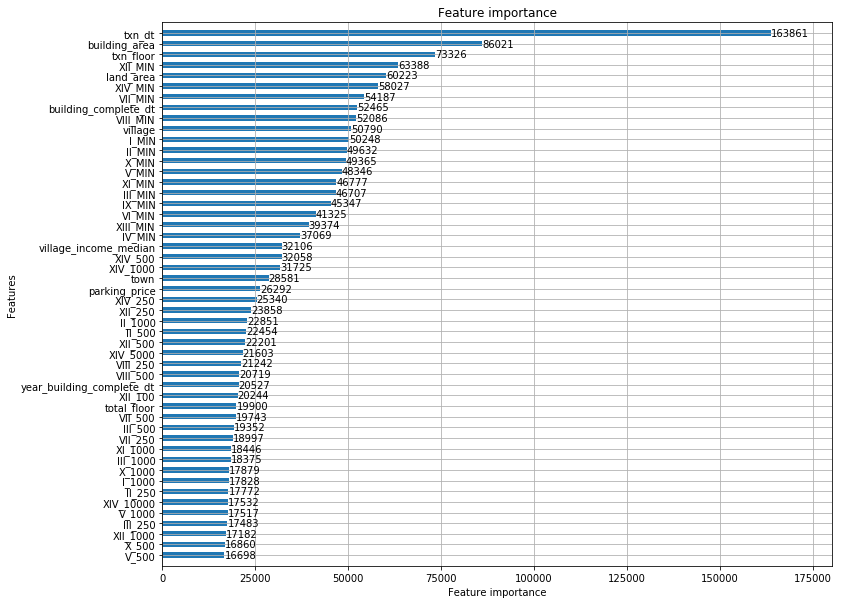

In [14]:
lgb.plot_importance(model, figsize=(12, 10), height=0.5, max_num_features=50)
plt.show()

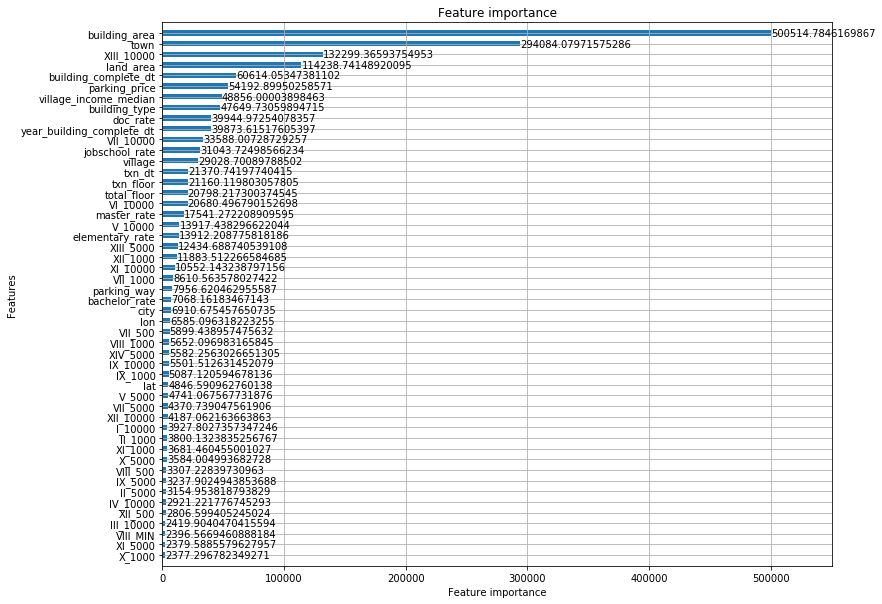

In [15]:
lgb.plot_importance(model, figsize=(12, 10), height=0.5, importance_type='gain', max_num_features=50)
plt.show()

### hist plot

In [22]:
df.head()

,building_id,building_material,city,txn_dt,total_floor,building_type,building_use,building_complete_dt,parking_way,parking_area,...,month_txn_dt,quarter_txn_dt,year_txn_dt,dow_building_complete_dt,day_in_year_building_complete_dt,month_building_complete_dt,quarter_building_complete_dt,year_building_complete_dt,dt_diff_building_complete_dt_txn_dt,log_total_price
0,e3mMIMR3JJqCaXz1,8,21,18674.0,4.0,3,2,6271.0,2,NaN,...,1,0,51,6,66,2,0,17,12403.0,13.381036
1,LgwzgklNvy4QCtq5,8,7,18800.0,5.0,1,2,7885.0,2,NaN,...,6,2,51,3,220,7,2,21,10915.0,15.015913
2,ucIR2NLLsC3T650L,8,7,19289.0,4.0,1,2,6028.0,2,NaN,...,10,3,52,1,188,6,2,16,13261.0,16.074236
3,jre1pJhcQj91Kdky,8,21,20385.0,24.0,0,2,18325.0,0,NaN,...,10,3,55,6,75,2,0,50,2060.0,16.469809
4,rQpYpY9nRG7X5mmr,1,21,20657.0,2.0,4,2,6880.0,2,NaN,...,7,2,56,6,310,10,3,18,13777.0,13.544637


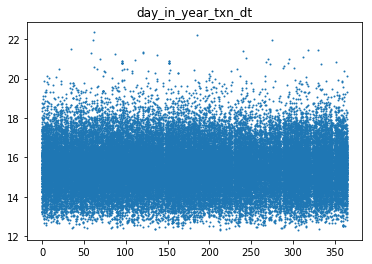

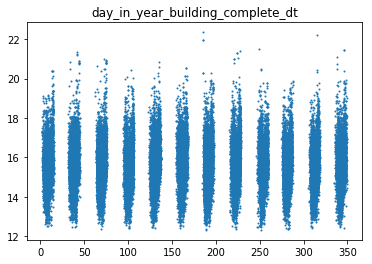

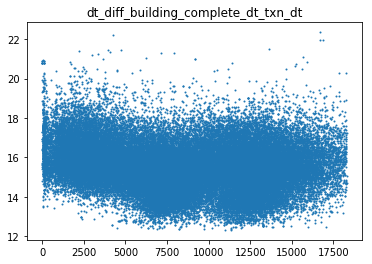

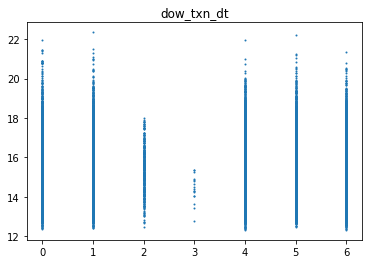

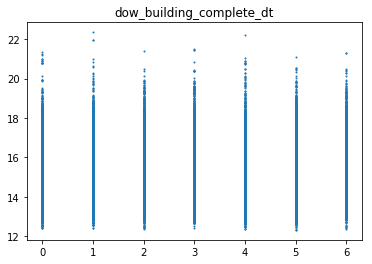

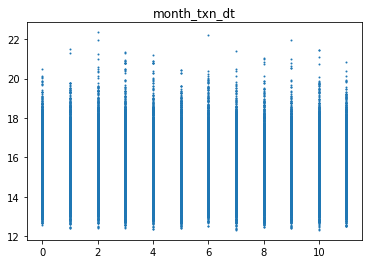

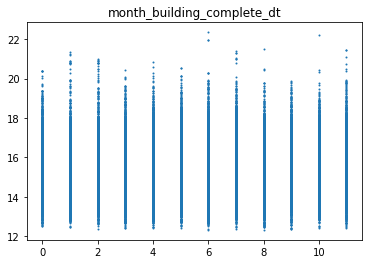

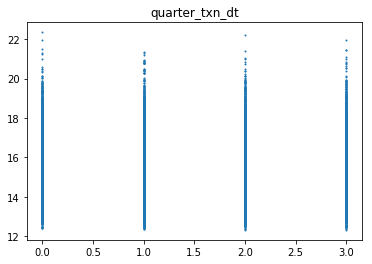

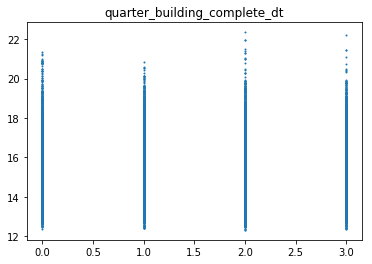

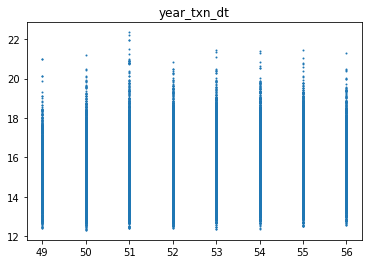

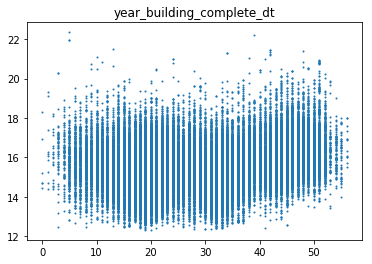

In [25]:
for c in cols_add:
    plt.scatter(df[c], df['log_total_price'], s=1)
    plt.title(c)
    plt.show()

In [29]:
for c in cols_add:
    print(c)
    display(df[c].value_counts(sort=False).sort_index())

day_in_year_txn_dt


0      199
1      204
2      209
3      185
4      188
5      169
6      166
7      171
8      188
9      157
10     153
11     147
12     128
13     136
14     204
15     183
16     166
17     188
18     192
19     171
20     195
21     150
22     184
23     136
24     133
25     117
26     169
27     180
28     170
29     178
      ... 
335    177
336    175
337    188
338    189
339    181
340    161
341    177
342    162
343    161
344    205
345    208
346    158
347    165
348     50
349     85
350    176
351    173
352    177
353    175
354    166
355    179
356    208
357    171
358    173
359    176
360    179
361    146
362    189
363    181
364    192
Name: day_in_year_txn_dt, Length: 365, dtype: int64

day_in_year_building_complete_dt


2       19
3      151
4      247
5      452
6      527
7      369
8      428
9      773
10     612
11     338
12     509
13     366
14     235
15      15
31       1
32      16
33     155
34     282
35     434
36     606
37     430
38     336
39     855
40     718
41     278
42     445
43     269
44     159
45      17
62       2
      ... 
305      1
306     15
307    117
308    211
309    367
310    495
311    358
312    289
313    681
314    551
315    251
316    468
317    404
318    189
319     18
335      2
336     31
337    129
338    315
339    486
340    550
341    395
342    303
343    897
344    620
345    260
346    539
347    361
348    200
349     11
Name: day_in_year_building_complete_dt, Length: 177, dtype: int64

dt_diff_building_complete_dt_txn_dt


5.0         2
7.0         1
8.0         1
10.0        1
11.0        2
14.0        1
17.0        2
20.0        1
21.0       10
23.0        1
24.0        1
25.0        2
27.0        2
28.0        1
29.0        1
30.0        1
32.0        1
33.0        3
35.0        1
36.0        3
37.0        2
38.0        2
39.0        1
40.0        1
41.0        1
42.0        1
43.0        1
44.0        1
45.0        2
47.0        1
           ..
18212.0     1
18213.0     1
18215.0     1
18220.0     1
18225.0     1
18226.0     3
18227.0     2
18233.0     1
18236.0     1
18237.0     2
18238.0     1
18239.0     1
18241.0     1
18243.0     1
18253.0     2
18254.0     2
18255.0     1
18256.0     1
18257.0     2
18258.0     1
18259.0     1
18264.0     1
18271.0     1
18276.0     2
18279.0     3
18283.0     1
18284.0     1
18285.0     1
18286.0     1
18287.0     2
Name: dt_diff_building_complete_dt_txn_dt, Length: 16404, dtype: int64

dow_txn_dt


0    12431
1    11297
2      413
3       17
4    11762
5    12135
6    11945
Name: dow_txn_dt, dtype: int64

dow_building_complete_dt


0    8568
1    7878
2    8157
3    8284
4    8935
5    9416
6    8762
Name: dow_building_complete_dt, dtype: int64

month_txn_dt


0     5299
1     4959
2     5355
3     5199
4     4869
5     5706
6     5029
7     4637
8     3866
9     4787
10    5191
11    5103
Name: month_txn_dt, dtype: int64

month_building_complete_dt


0     5041
1     5001
2     4977
3     4580
4     4931
5     5769
6     6365
7     5687
8     3882
9     4253
10    4415
11    5099
Name: month_building_complete_dt, dtype: int64

quarter_txn_dt


0    15613
1    15774
2    13532
3    15081
Name: quarter_txn_dt, dtype: int64

quarter_building_complete_dt


0    15019
1    15280
2    15934
3    13767
Name: quarter_building_complete_dt, dtype: int64

year_txn_dt


49     2730
50     6984
51     7649
52     8441
53     8837
54     9240
55    10153
56     5966
Name: year_txn_dt, dtype: int64

year_building_complete_dt


0        6
1       10
2       20
3       55
4       89
5      221
6      301
7      381
8      420
9      508
10     658
11     691
12     923
13     952
14    1157
15    1405
16    1493
17    1835
18    2144
19    2247
20    1346
21    1470
22    1301
23    1179
24     984
25     987
26    1044
27    1023
28    1024
29    1073
30    1744
31    2495
32    3107
33    2656
34    2047
35    1430
36    1755
37    1415
38     934
39     638
40     670
41    1006
42    1552
43    1900
44    1601
45    1653
46    1270
47    1008
48     856
49    1035
50     880
51     746
52     406
53      86
54     103
55      47
56      13
Name: year_building_complete_dt, dtype: int64

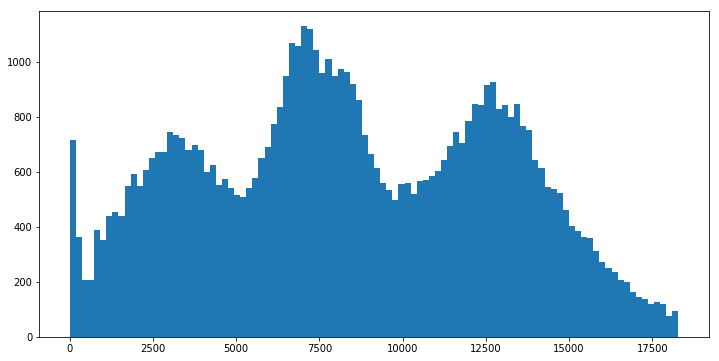

In [30]:
plt.figure(figsize=(12, 6))
plt.hist(df['dt_diff_building_complete_dt_txn_dt'], bins=100)
plt.show()

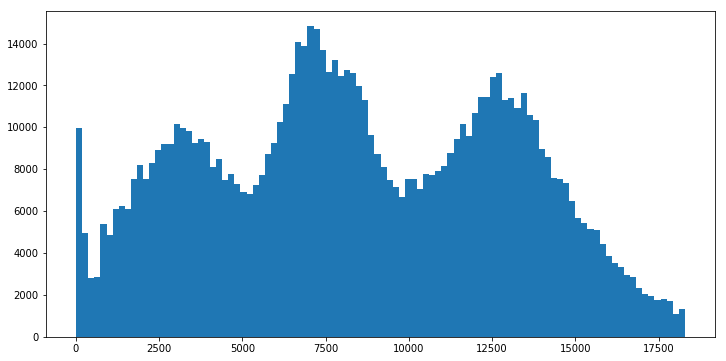

In [35]:
plt.figure(figsize=(12, 6))
plt.hist(df['dt_diff_building_complete_dt_txn_dt'], bins=100, weights=df['log_price_per_area'])
plt.show()

In [44]:
corr_price = df.corr()['log_total_price'].sort_values()
corr_price.reset_index().values

array([['highschool_rate', -0.48464986231167995],
       ['elementary_rate', -0.47880375410647363],
       ['junior_rate', -0.3391166138627617],
       ['death_rate', -0.3158821754328457],
       ['divorce_rate', -0.23916442689638315],
       ['XIII_MIN', -0.22921194035088044],
       ['XI_MIN', -0.20931137308386227],
       ['IV_MIN', -0.18366425346819376],
       ['VI_MIN', -0.18241790746469075],
       ['IX_MIN', -0.1773571151041386],
       ['VII_MIN', -0.1758726214319045],
       ['dt_diff_building_complete_dt_txn_dt', -0.17132760433088856],
       ['III_MIN', -0.1692461019304744],
       ['X_MIN', -0.16549517428247132],
       ['VIII_MIN', -0.15208838993560952],
       ['V_MIN', -0.15026865200393918],
       ['II_MIN', -0.13673573223435284],
       ['town_area', -0.12101316819003383],
       ['XII_MIN', -0.08460004633647746],
       ['I_MIN', -0.0781214616731818],
       ['IV_10', -0.02905030180198265],
       ['day_in_year_txn_dt', -0.010559036845583106],
       ['month_txn_dt',

In [45]:
corr_price_per_area = df.corr()['log_price_per_area'].sort_values()
corr_price_per_area.reset_index().values

array([['elementary_rate', -0.7089054964268418],
       ['highschool_rate', -0.6821100384498532],
       ['death_rate', -0.4652852052939398],
       ['junior_rate', -0.46240985285004177],
       ['XIII_MIN', -0.3490744291333071],
       ['VI_MIN', -0.337224970536651],
       ['VII_MIN', -0.32587538892685863],
       ['XI_MIN', -0.32282278611981524],
       ['III_MIN', -0.30381450648826985],
       ['IX_MIN', -0.2959869366314939],
       ['V_MIN', -0.29132313345956035],
       ['X_MIN', -0.287112338258755],
       ['IV_MIN', -0.28505214618232955],
       ['divorce_rate', -0.28237869524874754],
       ['VIII_MIN', -0.2758966157478793],
       ['I_MIN', -0.26279082028734707],
       ['II_MIN', -0.25440999869191844],
       ['XII_MIN', -0.23022019483210793],
       ['town_area', -0.22011281088479073],
       ['year_building_complete_dt', -0.08827900475915253],
       ['building_complete_dt', -0.08803699351305498],
       ['XIV_MIN', -0.08731459847498077],
       ['txn_floor', -0.0437903745

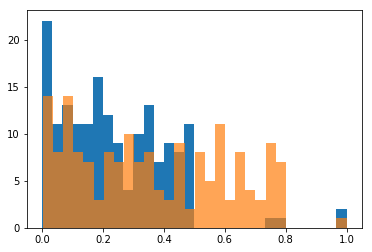

In [51]:
plt.hist(np.abs(corr_price.values), bins=30)
plt.hist(np.abs(corr_price_per_area.values), bins=30, alpha=0.7)
plt.show()

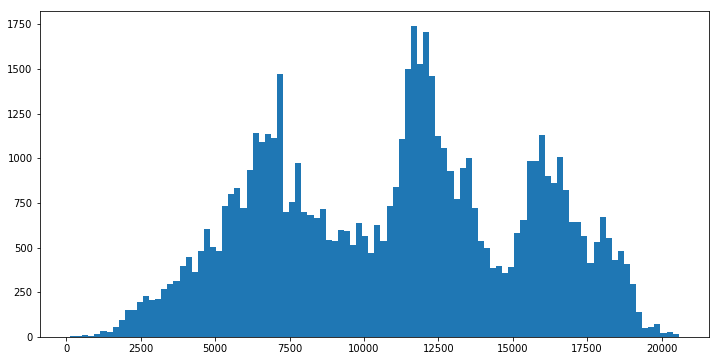

In [31]:
plt.figure(figsize=(12, 6))
plt.hist(df['building_complete_dt'], bins=100)
plt.show()

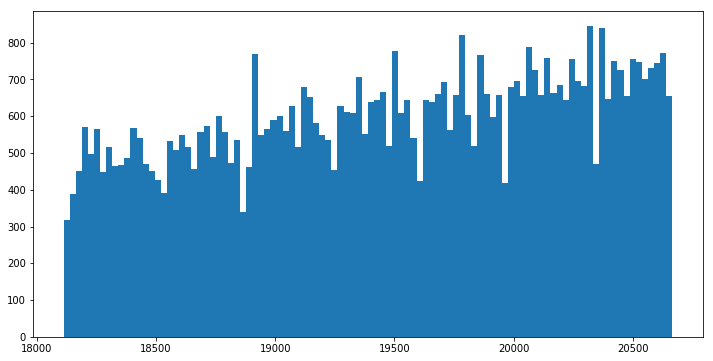

In [32]:
plt.figure(figsize=(12, 6))
plt.hist(df['txn_dt'], bins=100)
plt.show()

In [33]:
(df['txn_dt'] > df['building_complete_dt']).all()

True